In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import ee; ee.Initialize()

This notebook demonstrates how image values can be reduced along polyline. 

The _reduceImageProfile()_ function defined below reduces values along given line (_ee.Geometry.LineString_). Input line first gets split into a number of shorter line segments using _ee.Geometry.cutLines()_, which are then used to actually reduce image values.

In [2]:
def reduceImageProfile(image, line, reducer, scale):
    """Returns image values reduced along given line.

    Args:
        image: Image to be reduced.
        line: The line string used to query image values. The function splits
            the line into smaller segments with the length equal to scale.
            These smaller segments are then used to reduce image values with
            the reducer.
        reducer: Used used to reduce image values along line segments.
        scale: Indicates scale used to cut line into shorter line segment.

    Returns:
        An ee.FeatureCollection containing distance and iamge value properties. 
    """

    length = line.length()
    distances = ee.List.sequence(0, length, scale)
    lines = line.cutLines(distances).geometries()

    def generate_line_segment(l):
        l = ee.List(l)
        geom = ee.Geometry(l.get(0))
        distance = ee.Geometry(l.get(1))

        geom = ee.Algorithms.GeometryConstructors.LineString(geom.coordinates())

        return ee.Feature(geom, {'distance': distance})

    lines = lines.zip(distances).map(generate_line_segment)
    lines = ee.FeatureCollection(lines)

    # reduce image for every segment
    band_names = image.bandNames()

    return image.reduceRegions(lines, reducer.setOutputs(band_names), scale)

In [3]:
# image to be queried
image = ee.Image('USGS/NED')

# a line string used to qeury image values
line = ee.Geometry.LineString(
        [[-114.3843, 36.4257],
         [-114.3616, 36.4220],
         [-114.3514, 36.4203],
         [-114.3419, 36.4199],
         [-114.3116, 36.4228]])

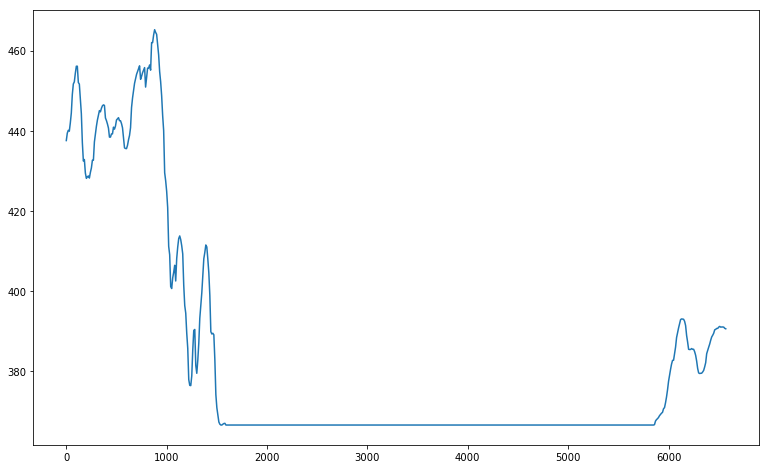

In [4]:
profile = reduceImageProfile(image, line, reducer=ee.Reducer.max(), scale=10)

# fetch resulting features (line segments) to the client
features = profile.getInfo()['features']

# extract distance and elevation properties from the resulting feature collection
x = [f['properties'].get('distance') for f in features]
y = [f['properties'].get('elevation') for f in features]

# plot
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(x, y)